# WOFOST Sensitivity and Uncertainty Analysis

This tutorial will cover the application of sensitivity and uncertainty methods on WOFOST.

The purpose of an uncertainty analysis is to quantify how uncertainty in the model inputs propagates to uncertainty in the model outputs. It is *output focused*, so we are more so interested in quantifying the uncertainty of the model outputs.

A closely related concept is a sensitivity analysis, which quantifies our variation in each of our inputs causes the most variation in the model outputs. It is *input focused*, so we are interested in quantifying the identifying the model inputs that most greatly influence the outputs.

In [14]:
import pandas as pd
import numpy as np
import yaml
import os.path as osp
import copy

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.sensitivity import (
	SensitivityAnalysisMethod,
	SensitivityAnalysisMethodModel,
)
from calisim.uncertainty import (
	UncertaintyAnalysisMethod,
	UncertaintyAnalysisMethodModel,
)
from calisim.statistics import MeanSquaredError

import pcse
from pcse.models import Wofost72_PP
from pcse.base import ParameterProvider
from pcse.input import NASAPowerWeatherDataProvider, YAMLAgroManagementReader, YAMLCropDataProvider, WOFOST72SiteDataProvider, DummySoilDataProvider

# Observed data

We will next load the observed field data.

Climate data will be from the Netherlands (latitude=52, longitude=5).

We will set WAV (initial amount of available soil moisture in excess of the wilting point) to 50.

We will use dummy soil data.

In [2]:
wdp = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
print(wdp)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER Source Native Resolution Daily Data
----Site characteristics----
Elevation:    3.5
Latitude:  52.000
Longitude:  5.000
Data available for 1984-01-01 - 2025-10-21
Number of missing days: 0



In [3]:
sited = WOFOST72SiteDataProvider(WAV=50)
print(sited)

{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 50.0, 'SMLIM': 0.4}


In [4]:
soild = DummySoilDataProvider()
print(soild)

{'SMFCF': 0.3, 'SM0': 0.4, 'SMW': 0.1, 'RDMSOL': 120, 'CRAIRC': 0.06, 'K0': 10.0, 'SOPE': 10.0, 'KSUB': 10.0}


In [5]:
cropd = YAMLCropDataProvider(fpath="data", force_reload=True)
print(cropd)

Crop parameters loaded from: /mnt/c/Users/james/projects/calisim-examples/workshop/6_wofost/data
Crop and variety not set: no active crop parameter set!



In [6]:
agro = YAMLAgroManagementReader(osp.join("data", "AGMT_C2_2020.agro"))
print(agro)

!!python/object/new:pcse.input.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2020-04-20:
    CropCalendar:
      crop_end_date: 2020-11-03
      crop_end_type: maturity
      crop_name: potato
      crop_start_date: 2020-04-20
      crop_start_type: sowing
      max_duration: 300
      variety_name: Potato_C2_C5
    StateEvents: null
    TimedEvents: null



In [9]:
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
wofost = Wofost72_PP(params, wdp, agro)
wofost.run_till_terminate()
observed_data = pd.DataFrame(wofost.get_output())
observed_data

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
0,2020-04-20,-0.100000,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
1,2020-04-21,-0.097173,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
2,2020-04-22,-0.093882,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
3,2020-04-23,-0.090047,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
4,2020-04-24,-0.085667,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
...,...,...,...,...,...,...,...,...,...,...,...,...
140,2020-09-07,1.963323,0.876336,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.128282,50.0,0.3,None
141,2020-09-08,1.972529,0.876336,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.088088,50.0,0.3,None
142,2020-09-09,1.982916,0.716347,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.085369,50.0,0.3,None
143,2020-09-10,1.992974,0.581502,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.071436,50.0,0.3,None


<Axes: xlabel='day', ylabel='LAI'>

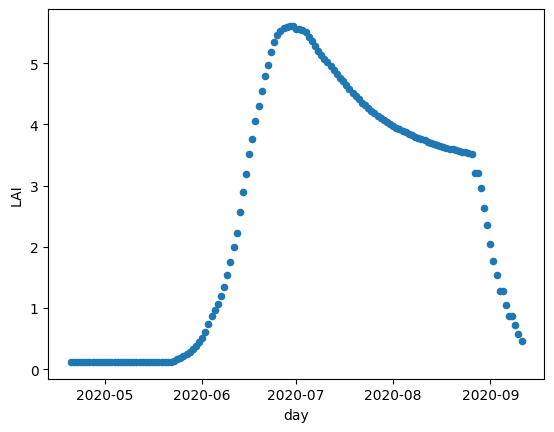

In [12]:
observed_data.plot.scatter("day", "LAI")

# Calibration procedure

## Uncertainty analysis

We will next run the calibration procedures against observed leaf area index (LAI) data. In this case, we will start with an uncertainty analysis.

We begin by specifying our parameter distributions. We will calibrate 2 parameters:

- SPAN: Life span of leaves growing at 35C
- TDWI: Initial total seed tuber dry weight

Parameter ranges were taken from [Time-Dependent Sensitivity Analysis of Wofost-Potato for Temperate and Subtropical Environments (Lui et al., 2025)](https://www.sciencedirect.com/science/article/pii/S116103012500303X)

In [13]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="TDWI",
			distribution_name="uniform",
			distribution_args=[75, 700],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="SPAN",
			distribution_name="uniform",
			distribution_args=[20, 50],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

In [16]:
def uncertainty_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    p = copy.deepcopy(params)
    for k in parameters:
        p.set_override(k, parameters[k])
                
    wofost = Wofost72_PP(p, wdp, agro)
    wofost.run_till_terminate()
    simulated_data = pd.DataFrame(wofost.get_output()).LAI.values
    return simulated_data

[We next run the uncertainty analysis using the Chaospy library](https://chaospy.readthedocs.io/en/master/).

Chaospy will perform a Monte Carlo simulation as determined by the joint distribution of our parameter specification. It will then fit a polynomial chaos expansion (PCE) surrogate model that learns the relationship between the model inputs and outputs. More specifically, Polynomial Chaos Expansion (PCE) approximates a complex model 

$$
Y = f(X_1, X_2, \dots, X_n)
$$

as a polynomial of the uncertain inputs:

$$
Y \approx \sum_{i} c_i \, \Psi_i(X_1, X_2, \dots, X_n)
$$

where:  
- $X_1, X_2, \dots, X_n$ are the **uncertain input variables**.  
- $\Psi_i$ are **orthogonal polynomials** chosen according to the input distributions:  
  - Hermite polynomials for Normal distributions  
  - Legendre polynomials for Uniform distributions  
- $c_i$ are **coefficients** fitted from the model outputs.
- $i$ are the terms in the polynomial expansion.

A secondary benefit of surrogate modelling is that we speed up the uncertainty analysis by reducing the number of executions of the simulation model; our PCE model acts as a cheaper surrogate of the full model. [A more detailed tutorial on PCE can be found here](https://maths-people.anu.edu.au/~jakeman/QuantifyingUncertainty/Tutorials/PCtutorial.html).

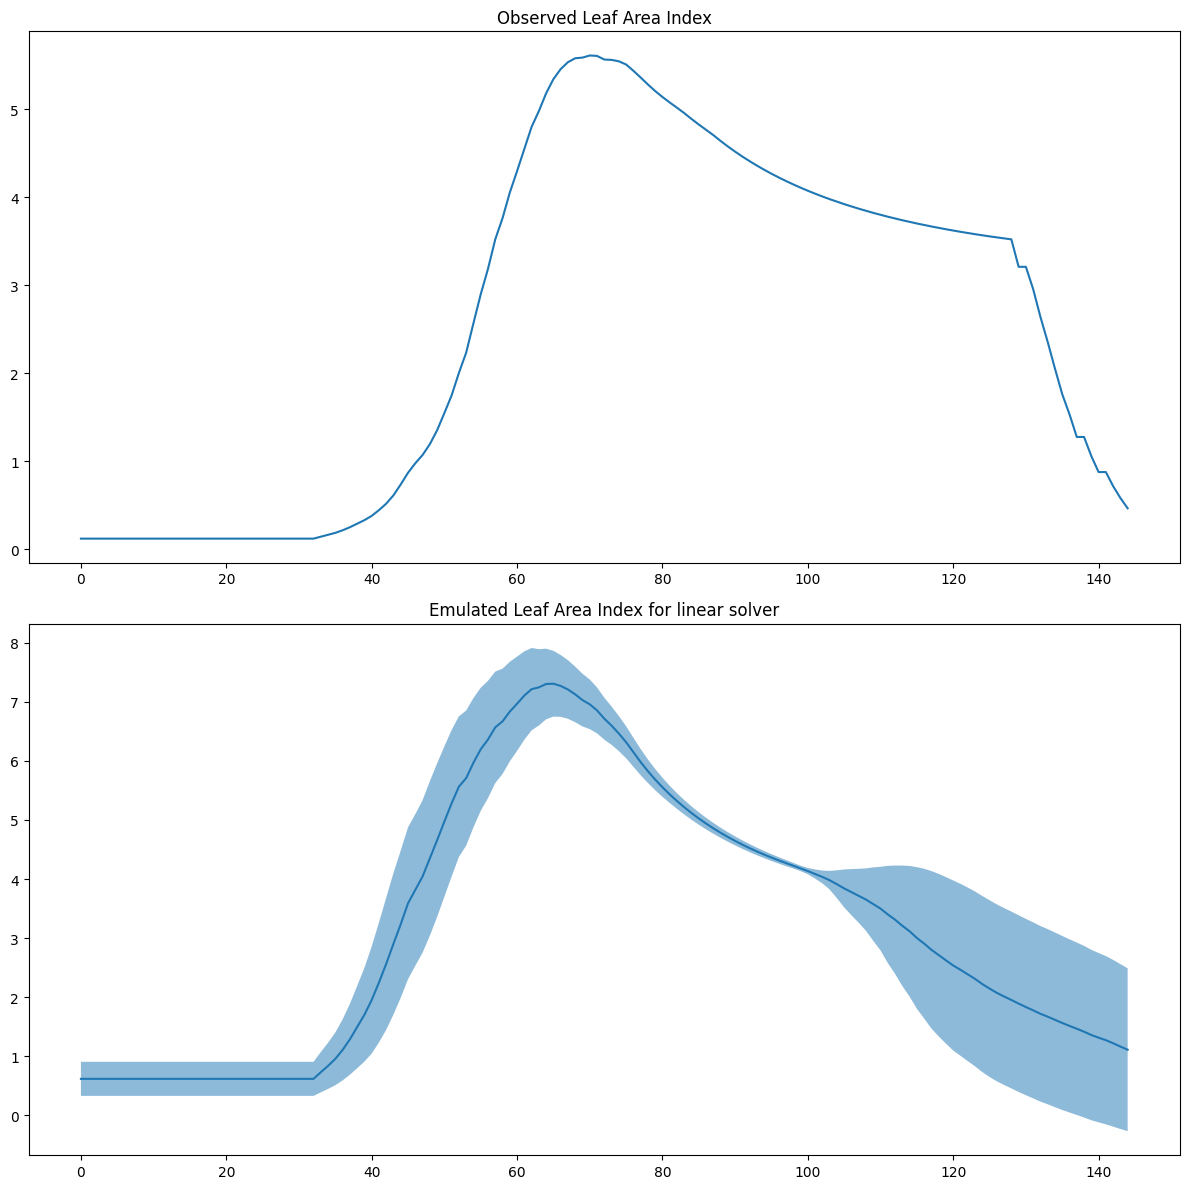

In [18]:
specification = UncertaintyAnalysisMethodModel(
	experiment_name="chaospy_uncertainty_analysis",
	parameter_spec=parameter_spec,
    observed_data=observed_data.LAI.values,
	solver="linear",
	algorithm="least_squares",
	method="sobol",
	order=2,
	n_samples=200,
	output_labels=["Leaf Area Index"],
	flatten_Y=True,
	batch=False,
	method_kwargs=dict(rule="cholesky", normed=False, cross_truncation=1.0),
)

calibrator = UncertaintyAnalysisMethod(
	calibration_func=uncertainty_func, specification=specification, engine="chaospy"
)

calibrator.specify().execute().analyze()

We can see the results of the uncertainty analysis above. We have a deterministic and mechanistic crop model, and by using a PCE surrogate model, we are able to construct a distribution of plausible trajectories for our simulated LAI values. We have the mean trajectory of our predicted LAI, alongside its standard deviation.

As we have yet to perform calibration, we also see that our trajectory is quite off from the observed data.

An uncertainty analysis is particulary useful for both temporal and spatial modelling (in our case temporal), as it tracks how uncertainty in model inputs or conditions spreads and evolves across both space and time. It helps reveal where and when predictions are most reliable in dynamic, location-dependent systems.

## Sensitivity analysis

We will next perform a sensitivity analysis to derive sensitivity indices for our 2 parameters (TDWI and SPAN). This will allow us to prioritise specific parameters for calibration using a combination of a data-driven approach (with our observed LAI measurements), consultation with domain experts, and a review of the available literature.

We will calculate Sobol sensitivity indices to quantify how the variation in the 2 input parameters of the model influences the variation in LAI. [A detailed explaination of the Sobol methods may be found here.](https://link.springer.com/chapter/10.1007/978-3-030-51862-2_6). 

We'll first define a sensitivity analysis function which will return the discrepancy between observed and simulated LAI values as determined by the mean squared error (MSE) metric. There are alternatives...we could return sensitivity indices for each time step if we wanted to perform a time-varying sensitivity analysis for instance. But we'll keep things simple.

In [19]:
def sensitivity_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    p = copy.deepcopy(params)
    for k in parameters:
        p.set_override(k, parameters[k])
                
    wofost = Wofost72_PP(p, wdp, agro)
    wofost.run_till_terminate()
    simulated_data = pd.DataFrame(wofost.get_output()).LAI.values
    
    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

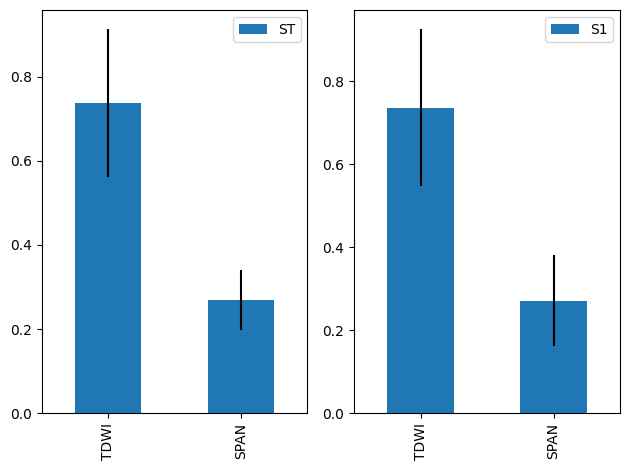

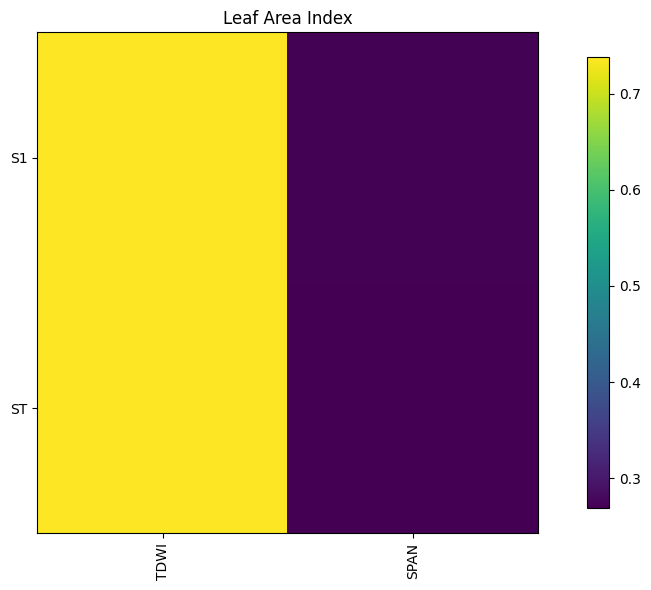

In [22]:
specification = SensitivityAnalysisMethodModel(
	experiment_name="salib_sensitivity_analysis",
	parameter_spec=parameter_spec,
    observed_data=observed_data.LAI.values,
	method="sobol",
	n_samples=128,
    n_jobs=1,
	output_labels=["Leaf Area Index"],
	verbose=True,
	batched=False,
	method_kwargs=dict(calc_second_order=False, scramble=True),
	analyze_kwargs=dict(
		calc_second_order=False,
		num_resamples=200,
		conf_level=0.95,
	),
)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="salib"
)

calibrator.specify().execute().analyze()

The variation in the discrepancy between simulated and observed LAI (the output) is most sensitive to variation in TDWI (the input), which is the initial total seed tuber dry weight

We can see that varation in SPAN has less of an influence.  

Hence, we would want to focus on calibrating TDWI first. To reduce the possibility of overfitting, we may hold less influential parameters, such as SPAN, constant while varying more influential parameters such as TDWI.